In [6]:
!pip install transformers datasets torch gradio nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [27]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import random
import gradio as gr
import matplotlib.pyplot as plt
from collections import Counter

# Load dataset
dataset = load_dataset("clinc_oos", "imbalanced", split="train")
print(f"Original dataset size: {len(dataset)}")

# Get the intent label mapping
intent_mapping = dataset.features["intent"].int2str
intent_labels = {i: intent_mapping(i) for i in range(len(set(dataset["intent"])))}
print("Intent Mapping:", intent_labels)

# Use the correct numbers for insurance-related intents
insurance_intent_numbers = [64, 74, 70, 56, 27, 111, 69]  # Replace with correct ones found

# Apply filter
dataset = dataset.filter(lambda example: example["intent"] in insurance_intent_numbers)

# Check dataset size after filtering
print(f"Dataset size after filtering: {len(dataset)}")

# Ensure the dataset is not empty
if len(dataset) == 0:
    raise ValueError("Error: No insurance-related data found! Try different intent numbers from the printed list.")


Original dataset size: 10625
Intent Mapping: {0: 'restaurant_reviews', 1: 'nutrition_info', 2: 'account_blocked', 3: 'oil_change_how', 4: 'time', 5: 'weather', 6: 'redeem_rewards', 7: 'interest_rate', 8: 'gas_type', 9: 'accept_reservations', 10: 'smart_home', 11: 'user_name', 12: 'report_lost_card', 13: 'repeat', 14: 'whisper_mode', 15: 'what_are_your_hobbies', 16: 'order', 17: 'jump_start', 18: 'schedule_meeting', 19: 'meeting_schedule', 20: 'freeze_account', 21: 'what_song', 22: 'meaning_of_life', 23: 'restaurant_reservation', 24: 'traffic', 25: 'make_call', 26: 'text', 27: 'bill_balance', 28: 'improve_credit_score', 29: 'change_language', 30: 'no', 31: 'measurement_conversion', 32: 'timer', 33: 'flip_coin', 34: 'do_you_have_pets', 35: 'balance', 36: 'tell_joke', 37: 'last_maintenance', 38: 'exchange_rate', 39: 'uber', 40: 'car_rental', 41: 'credit_limit', 42: 'oos', 43: 'shopping_list', 44: 'expiration_date', 45: 'routing', 46: 'meal_suggestion', 47: 'tire_change', 48: 'todo_list', 

Filter:   0%|          | 0/10625 [00:00<?, ? examples/s]

Dataset size after filtering: 225


LOADING DATASET

Balanced dataset size: 350
Class distribution after balancing: Counter({64: 50, 74: 50, 70: 50, 56: 50, 27: 50, 111: 50, 69: 50})


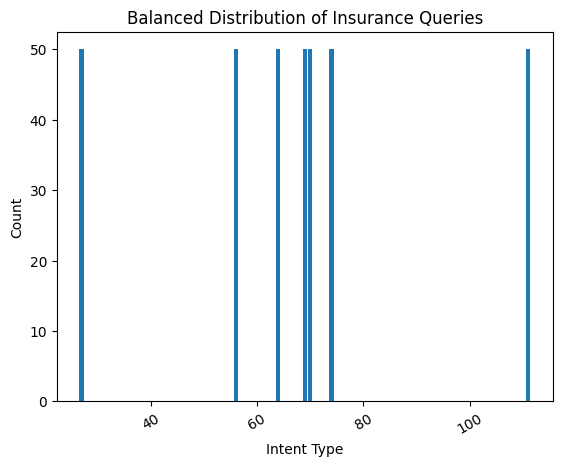

In [28]:
# Get examples for each class
insurance_data = {intent: [ex for ex in dataset if ex["intent"] == intent] for intent in insurance_intent_numbers}

# Find the max class size to balance dataset
max_size = max(len(insurance_data[intent]) for intent in insurance_intent_numbers)

# Oversample minority classes
for intent in insurance_intent_numbers:
    while len(insurance_data[intent]) < max_size:
        insurance_data[intent].append(random.choice(insurance_data[intent]))

# Combine balanced dataset
balanced_dataset = Dataset.from_dict({
    "text": [ex["text"] for intent in insurance_intent_numbers for ex in insurance_data[intent]],
    "intent": [ex["intent"] for intent in insurance_intent_numbers for ex in insurance_data[intent]]
})

print(f"Balanced dataset size: {len(balanced_dataset)}")

# Ensure dataset isn't empty before proceeding
if len(balanced_dataset) == 0:
    raise ValueError("Error: Balanced dataset is empty after oversampling.")

# Check new class distribution
intent_counts_balanced = Counter(balanced_dataset["intent"])
print("Class distribution after balancing:", intent_counts_balanced)

# Plot the balanced dataset
plt.bar(intent_counts_balanced.keys(), intent_counts_balanced.values())
plt.xlabel("Intent Type")
plt.ylabel("Count")
plt.title("Balanced Distribution of Insurance Queries")
plt.xticks(rotation=30)
plt.show()


In [39]:
# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token

def preprocess_data(examples):
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=50)

    # Shift labels so that the model learns prediction, not copying
    tokens["labels"] = tokens["input_ids"].copy()
    tokens["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in tokens["labels"]]

    return {"input_ids": tokens["input_ids"], "attention_mask": tokens["attention_mask"], "labels": tokens["labels"]}

# Apply preprocessing
tokenized_dataset = balanced_dataset.map(preprocess_data, batched=True, remove_columns=["text", "intent"])


print(f"Tokenized dataset sample: {tokenized_dataset[0]}")



Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Tokenized dataset sample: {'input_ids': [11152, 502, 832, 262, 1429, 286, 1972, 649, 5096, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [11152, 502, 832, 262, 1429, 286, 1972, 649, 5096, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]}


In [40]:
# Load pre-trained GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Split dataset into training and evaluation
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
print(f"Train dataset size: {len(split_dataset['train'])}")
print(f"Test dataset size: {len(split_dataset['test'])}")

# Ensure dataset is not empty
if len(split_dataset["train"]) == 0 or len(split_dataset["test"]) == 0:
    raise ValueError("Error: Train or test dataset is empty after splitting.")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir="./logs",
    remove_unused_columns=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    data_collator=None,
)

# Train model
trainer.train()


Train dataset size: 280
Test dataset size: 70


Epoch,Training Loss,Validation Loss
1,No log,2.290633
2,No log,1.945058
3,No log,1.837028
4,No log,1.842805
5,No log,1.821311
6,No log,1.790111
7,No log,1.835493
8,1.292000,1.828247
9,1.292000,1.822429
10,1.292000,1.836005


TrainOutput(global_step=700, training_loss=1.1053248487200056, metrics={'train_runtime': 196.375, 'train_samples_per_second': 14.258, 'train_steps_per_second': 3.565, 'total_flos': 71447040000000.0, 'train_loss': 1.1053248487200056, 'epoch': 10.0})

In [41]:
def generate_response(prompt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check available device
    model.to(device)  # Move model to the correct device

    inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(device)  # Move input to same device
    attention_mask = torch.ones(inputs.shape, device=device)  # Ensure attention mask is set

    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=50, pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test responses
print(generate_response("How do I file an insurance claim?"))
print(generate_response("What does my policy cover?"))


How do I file an insurance claim?

Insurance plans provide a number of benefits, including a number of benefits provided by my insurance plan, to help me pay my bills. Your insurance benefits include benefits provided by my insurance plan, benefits provided
What does my policy cover?

My insurance benefits include benefits provided by my insurance plan, benefits provided by my insurance plan's member agencies, and benefits provided by my insurance plan's insurance plan benefits program. My benefits include benefits provided by my insurance


In [42]:
test_questions = [
    "How do I file an insurance claim?",
    "What does my policy cover?",
    "Can I change my coverage options?",
    "How long does it take to process a claim?",
    "What should I do if my claim is denied?",
]

for question in test_questions:
    print(f"User: {question}")
    print(f"Bot: {generate_response(question)}\n")

User: How do I file an insurance claim?
Bot: How do I file an insurance claim?

Insurance plans provide a number of benefits, including a number of benefits provided by my insurance plan, to help me pay my bills. Your insurance benefits include benefits provided by my insurance plan, benefits provided

User: What does my policy cover?
Bot: What does my policy cover?

My insurance benefits include benefits provided by my insurance plan, benefits provided by my insurance plan's member agencies, and benefits provided by my insurance plan's insurance plan benefits program. My benefits include benefits provided by my insurance

User: Can I change my coverage options?
Bot: Can I change my coverage options?

Your health plan gives you the right to change your insurance to a new low monthly premium plan that gives you the same benefits as my health plan but gives you a lower deductible for my health benefits. Your health

User: How long does it take to process a claim?
Bot: How long does it ta

In [44]:
from math import exp

def compute_perplexity(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Get the device
    inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)  # Move inputs to the device
    model.to(device)  # Move the model to the device if it's not already there

    loss = model(inputs, labels=inputs).loss
    return exp(loss.item())

print("Perplexity:", compute_perplexity("How do I file an insurance claim?"))

Perplexity: 70.9443083456155


In [45]:
def chatbot(input_text):
    return generate_response(input_text)

# Create interactive chatbot UI
demo = gr.Interface(
    fn=chatbot,
    inputs="text",
    outputs="text",
    title="Insurance Chatbot",
    description="Ask me anything about your insurance policy!"
)

demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c209240db0b0944b49.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
